Following http://pymc-devs.github.io/pymc3/notebooks/gaussian-mixture-model-advi.html; using https://archive.ics.uci.edu/ml/datasets/Wholesale+customers.

### Set up the system

In [1]:
%matplotlib inline

import pymc3             as pm
import theano.tensor     as tt
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd

from pymc3.math            import logsumexp
from theano.tensor.nlinalg import det

### Access the data

In [2]:
df_data = pd.read_csv('https://raw.githubusercontent.com/LEggert/Probabilistic-Programming/master/use_case_clustering/use_case_clustering_data.csv')

In [3]:
df_data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
df_data.shape

(440, 8)

Let us take two dimensions, e. g. "Milk" and "Detergents Paper".

In [5]:
n_samples = 200
data = df_data[['Milk', 'Detergents_Paper']].iloc[:n_samples].values

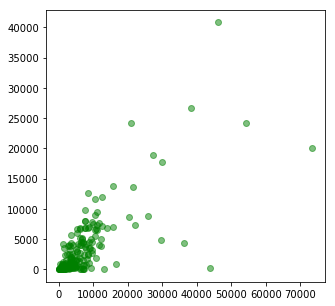

In [6]:
plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.5)

### Specify the model

In [7]:
# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value)
                 for i, mu in enumerate(mus)]

        return tt.sum(pm.logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

In [8]:
with pm.Model() as gauss_mix:
    mus = [pm.MvNormal('mu_%d' % i,
                    mu=pm.floatX(np.zeros(2)),
                    tau=pm.floatX(0.1 * np.eye(2)),
                    shape=(2,))
           for i in range(2)]
    pi = pm.Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = pm.DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)

### Perform inference

In [9]:
with gauss_mix:
    start = pm.find_MAP()
    step  = pm.Metropolis()
    trace = pm.sample(1000, step, start=start)

Optimization terminated successfully.
         Current function value: 4440503823.914504
         Iterations: 29
         Function evaluations: 56
         Gradient evaluations: 48


100%|██████████| 1500/1500 [00:02<00:00, 600.86it/s]


### Inspect the result

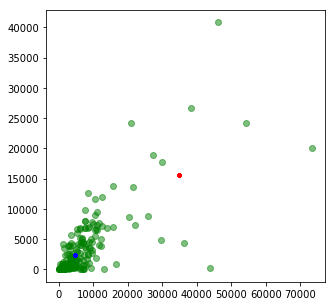

In [10]:
plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
mu_0, mu_1 = trace['mu_0'], trace['mu_1']
plt.scatter(mu_0[-500:, 0], mu_0[-500:, 1], c="r", s=10)
plt.scatter(mu_1[-500:, 0], mu_1[-500:, 1], c="b", s=10)

Alternatively, a Dirichlet process mixture model can be used (please cf. e. g. http://pymc-devs.github.io/pymc3/notebooks/dp_mix.html).